In [1]:
# !pip install catboost

In [2]:
# !pip install shap

In [3]:
# !pip install plotly

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import catboost
from time import time
import shap
import plotly.graph_objects as go

In [5]:
#Use case: Telco Customer Churn prediction dataset
#Read dataset
data_df = pd.read_csv("churn_data.csv")

In [6]:
data_df.head(2)

customerID  gender  SeniorCitizen  ... MonthlyCharges TotalCharges  Churn
0  7590-VHVEG  Female              0  ...          29.85        29.85     No
1  5575-GNVDE    Male              0  ...          56.95       1889.5     No

[2 rows x 21 columns]

In [7]:
#Variable Description
def description(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['PercMissing'] = df.isnull().sum().values / df.isnull().count().values
    summary['Uniques'] = df.nunique().values
    return summary
print('**Variable Description of  train Data:**')
description(data_df)

**Variable Description of  train Data:**
Dataset Shape: (7043, 21)


Name   dtypes  Missing  PercMissing  Uniques
0         customerID   object        0          0.0     7043
1             gender   object        0          0.0        2
2      SeniorCitizen    int64        0          0.0        2
3            Partner   object        0          0.0        2
4         Dependents   object        0          0.0        2
5             tenure    int64        0          0.0       73
6       PhoneService   object        0          0.0        2
7      MultipleLines   object        0          0.0        3
8    InternetService   object        0          0.0        3
9     OnlineSecurity   object        0          0.0        3
10      OnlineBackup   object        0          0.0        3
11  DeviceProtection   object        0          0.0        3
12       TechSupport   object        0          0.0        3
13       StreamingTV   object        0          0.0        3
14   StreamingMovies   object        0          0.0        3
15          Contract   object        0          0.0        3
16  PaperlessBilling   object        0          0.0        2
17     PaymentMethod   object        0          0.0        4
18    MonthlyCharges  float64        0          0.0     1585
19      TotalCharges   object        0          0.0     6531
20             Churn   object        0          0.0        2

In [8]:
# The customerID column isnt useful as the feature us used for identification of customers. 
data_df.drop(["customerID"],axis=1,inplace = True)

In [9]:
data_df['TotalCharges'] = pd.to_numeric(data_df['TotalCharges'],errors='coerce')
#Fill the missing values with with the median value
data_df['TotalCharges'] = data_df['TotalCharges'].fillna(data_df['TotalCharges'].median())

In [10]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [11]:
#Encode the target label
data_df['Churn'] = data_df['Churn'].apply(lambda x: 1 if x =='Yes' else 0)

In [12]:
data_df.head(2)

gender  SeniorCitizen Partner  ... MonthlyCharges  TotalCharges Churn
0  Female              0     Yes  ...          29.85         29.85     0
1    Male              0      No  ...          56.95       1889.50     0

[2 rows x 20 columns]

In [13]:
from pandas.api.types import is_numeric_dtype
def get_categorical_indices(data):
  cats = []
  for col in data.columns:
    if is_numeric_dtype(data[col]):
      pass
    else:
      cats.append(col)
  cat_indices = []
  for col in cats:
    cat_indices.append(data.columns.get_loc(col))
  return cat_indices
categorical_indices = get_categorical_indices(data_df)
categorical_indices

[0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [14]:
X = data_df.drop("Churn", axis = 1)
y = data_df['Churn']

In [15]:
#Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=42)

In [16]:
#Baseline model
from catboost import CatBoostClassifier
model = CatBoostClassifier(one_hot_max_size = 10, iterations = 500)
model.fit(
    X_train, y_train,
    cat_features = categorical_indices,
    verbose = False
)

## Feature Importance

In [17]:
from catboost import Pool

In [18]:
#For PredictionValuesChange
feature_scores_pvc = model.get_feature_importance(Pool(X_test, label=y_test, cat_features=categorical_indices), type='PredictionValuesChange')

In [19]:
fig1 = go.Figure(go.Bar(
            x=feature_scores_pvc,
            y=X_train.columns,
            orientation='h'))

fig1.update_layout(
    title="Feature Importance using PredictionValuesChange technique",
    xaxis_title="Score",
    yaxis_title="Features",
    )
fig1.show()

In [20]:
#For LossFunctionChange
feature_scores_lfc = model.get_feature_importance(Pool(X_test, label=y_test, cat_features=categorical_indices), type='LossFunctionChange')

In [21]:
fig2 = go.Figure(go.Bar(
            x=feature_scores_lfc,
            y=X_train.columns,
            orientation='h'))

fig2.update_layout(
    title="Feature Importance using LossFunctionChange technique",
    xaxis_title="Score",
    yaxis_title="Features",
    )

fig2.show()

In [22]:
# #SHAP analysis
# shap_values = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_indices), 
#                                                                      type="ShapValues")

In [23]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

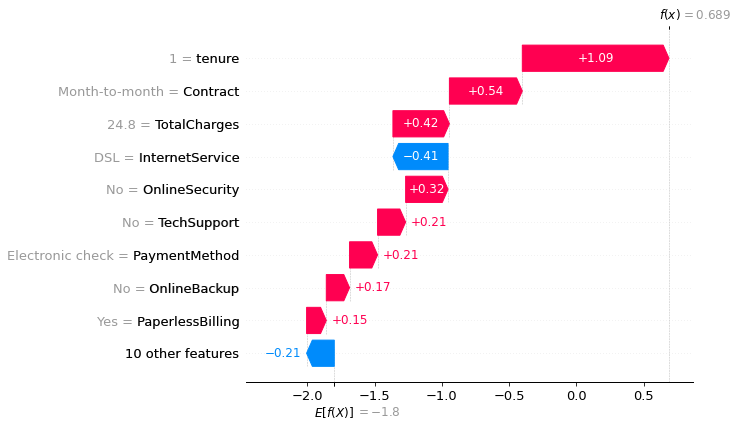

In [24]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [25]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values[0])

In [26]:
shap_values_ = model.get_feature_importance(Pool(X_train, label=y_train,cat_features=categorical_indices), 
                                                                     type="ShapValues")
expected_value = shap_values_[0,-1]
shap_values_selected = shap_values_[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values_selected[5,:], X_train.iloc[1,:])

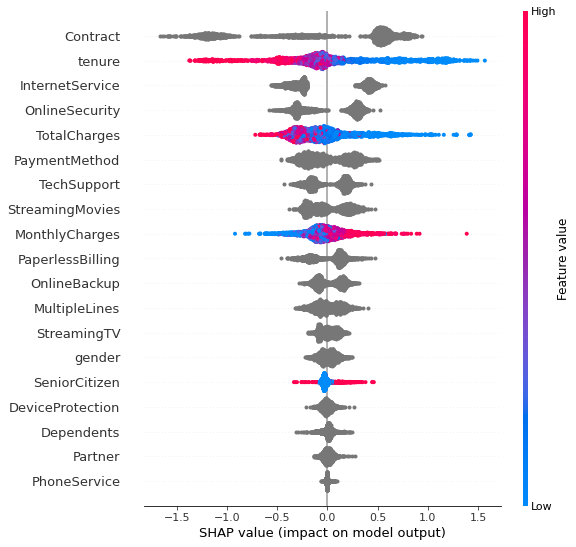

In [27]:
# summarize the effects of all the featuresx
shap.summary_plot(shap_values, X_test)

In [28]:
# visualize all the training set predictions
shap.initjs()
shap.plots.force(shap_values)

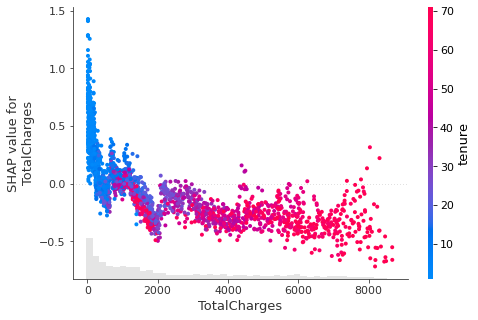

In [29]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"TotalCharges"], color=shap_values)

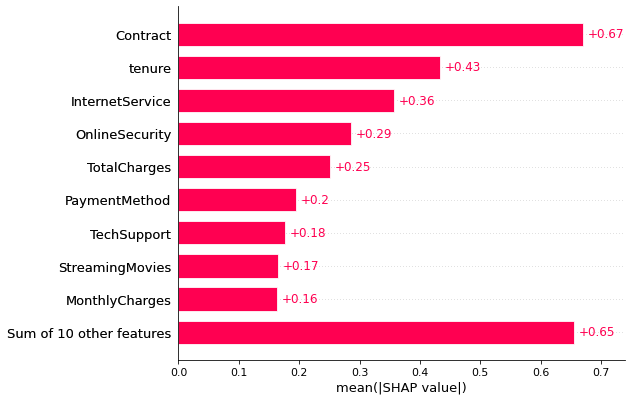

In [30]:
shap.plots.bar(shap_values)

In [31]:
fi = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_indices), 
                                                                     type="Interaction")

In [32]:
fi_new = []
for k,item in enumerate(fi):  
    first = X_test.dtypes.index[fi[k][0]]
    second = X_test.dtypes.index[fi[k][1]]
    if first != second:
        fi_new.append([first + "_" + second, fi[k][2]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.



In [33]:
feature_score = pd.DataFrame(fi_new,columns=['Feature-Pair','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

In [34]:
feature_score.head()

Feature-Pair      Score
0   MonthlyCharges_TotalCharges  10.578398
1         tenure_MonthlyCharges   5.936670
2           tenure_TotalCharges   5.342246
3    SeniorCitizen_TotalCharges   0.866434
4  SeniorCitizen_MonthlyCharges   0.618766

In [35]:
fig3 = go.Figure(go.Bar(
            y=feature_score['Feature-Pair'],
            x=feature_score['Score'],
            orientation='h'))

fig3.update_layout(
    title="Pairwise feature importance",
    yaxis_title="Feature pair",
    xaxis_title="Score",
    width=1000, height=500

    )
fig3

# run['pairwise_feature_importance'].upload(neptune.types.File.as_html(fig3))

In [36]:
feature = 'SeniorCitizen'
res = model.calc_feature_statistics(X_train, y_train, feature, plot=True)

In [37]:
res

{'binarized_feature': array([0, 0, 0, ..., 0, 1, 0]),
 'borders': array([0.5], dtype=float32),
 'mean_prediction': array([-2.005569 , -0.7196244], dtype=float32),
 'mean_target': array([0.23357488, 0.41518986], dtype=float32),
 'mean_weighted_target': array([], dtype=float32),
 'objects_per_bin': array([4140,  790], dtype=uint32),
 'predictions_on_varying_feature': array([-1.81898322, -1.68347311])}